# RNNs을 사용한 Image Captioning 
기본적인 순환 신경망(vanilla RNN)을 구현하고, 그것을 사용하여 이미지에 대한 새로운 캡션을 생성할 수 있는 모델을 훈련시키는 것을 할 것입니다.

In [51]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

# from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
# from utils.rnn_layers import *
# from utils.captioning_solver import CaptioningSolver
# from utils.classifiers.rnn import CaptioningRNN
# from utils.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
# from utils.image_utils import image_from_url

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

ModuleNotFoundError: No module named 'cs231n.gradient_check'

## h5py 설치

우리가 사용할 COCO 데이터셋은 HDF5 형식으로 저장되어 있다. HDF5 파일을 로드하려면 h5py 파이썬 패키지를 설치해야 한다. 명령줄에서 다음을 실행하시오:<br >
`pip install h5py` <br >
만약 권한 오류가 발생한다면, 루트 권한으로 명령을 실행해야 할 수도 있습니다: <br >
`sudo pip install h5py` <br >

또한 Jupyter 노트북에서 명령 앞에 "!" 문자를 붙여 직접 명령을 실행해야 할 수도 있습니다.

In [9]:
!pip install h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 5.9 MB/s eta 0:00:0000:0100:01m


# Microsoft COCO 데이터셋 소개

이 과제에서는 이미지 캡셔닝 분야에서 표준처럼 사용되는 [Microsoft COCO dataset](http://mscoco.org/) 데이터셋을 사용한다. 이 데이터셋에는

훈련 이미지 80,000장, <br >
검증 이미지 40,000장
이 포함되어 있으며, 각 이미지마다 Amazon Mechanical Turk 작업자 5명이 작성한 캡션이 달려 있다.
즉, 한 이미지에 대해 서로 다른 사람이 설명한 문장 5개가 존재한다.

# 데이터 준비

이미 `Week3/utils/datasets` 디렉토리에서 `get_assignment3_data.sh` 스크립트를 실행해 데이터를 내려받아보자.<br >
참고로 COCO 관련 파일은 약 1GB 정도이므로 다운로드에 시간이 걸릴 수 있다.

# 전처리

원본 이미지는 전체 합치면 약 20GB에 달하기 때문에 과제에서는 포함하지 않았습니다.<br >
대신 편리하게 사용할 수 있도록 다음과 같은 형태의 데이터만 제공합니다.<br >

1) VGG-16 특징 벡터 제공<br >

모든 이미지를 VGG-16(net)을 이용해 fc7 layer에서 feature를 추출해 두었습니다.<br >
파일은 다음과 같습니다:

`train2014_vgg16_fc7.h5` <br >

`val2014_vgg16_fc7.h5`

이 벡터는 각각 4096차원으로 구성됩니다.

2) PCA로 차원 축소한 버전도 제공<br >

4096차원은 학습과 메모리 모두 부담이기 때문에, PCA를 사용해 512차원으로 줄인 특징도 제공합니다.<br >

`train2014_vgg16_fc7_pca.h5`<br >

`val2014_vgg16_fc7_pca.h5`<br >

훈련 과정에서는 보통 이 PCA 버전을 사용하면 더 효율적입니다.

# 캡션은 문자열이 아닌 정수 시퀀스로 저장됨.

문자열을 직접 처리하면 비효율적이므로, 캡션은 다음 방식으로 인코딩되어 있습니다.<br >

단어마다 고유한 정수 ID 부여, 하나의 캡션은 정수 시퀀스로 표현<br >

<b>정수 ID ↔ 단어 매핑<b/>은 `coco2014_vocab.json` 파일에 저장되어 있습니다.

정수 배열을 다시 문장으로 바꾸고 싶다면

`decode_captions`
함수를 사용하면 됩니다.

# 이미지 캡셔닝에 필요한 특수 토큰 설명

캡션 처리에는 몇 가지 중요한 특수 토큰이 필요합니다:<br >

`<START> : 문장 시작`

`<END> : 문장 끝`

`<UNK> : 희귀하거나 사전에 없는 단어`

`<NULL> : 짧은 문장을 맞춰주기 위한 padding 토큰`

훈련 시 `<NULL>` 위치에서는 손실(loss)이나 gradient를 계산하지 않습니다.
이런 세부처리는 이미 과제 코드에서 모두 구현해두었기 때문에 직접 신경 쓸 필요는 없습니다.

# COCO 데이터를 한 번에 로드하는 방법

다음 항목을 모두 포함한 데이터 로더가 이미 제공되어 있습니다:<br >
`캡션`<br >
`이미지 feature`<br >
`이미지 URL`<br >
`어휘(vocab)`<br >

이를 불러오기 위해서는 `utils/coco_utils.py` 내부의
load_coco_data 함수를 사용한다.
주어진 셀을 실행하면 모든 데이터가 메모리에 로드됩니다.

In [38]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


데이터를 본격적으로 다루기 전에, 데이터셋의 예시들을 직접 확인해보자.

`load_coco_data` 함수가 반환한 데이터 구조에서 미니배치를 뽑고 싶다면, `utils/coco_utils.py`에 있는 `sample_coco_minibatch` 함수를 사용할 수 있다.<br >
아래 코드를 실행하면 작은 크기의 학습용 미니배치를 샘플링하고, 해당 이미지와 캡션을 확인할 수 있다.<br >
이 셀을 여러 번 실행해보면 데이터셋의 특성과 다양성을 감각적으로 이해하는 데 도움이 된다.<br >

또한 캡션은 `decode_captions` 함수를 사용해 정수 시퀀스를 다시 문자열로 변환하고, 이미지는 `Flickr URL`을 이용해 실시간으로 다운로드해 표시한다.<br >
따라서 이미지를 보기 위해서는 인터넷 연결이 반드시 필요하다.

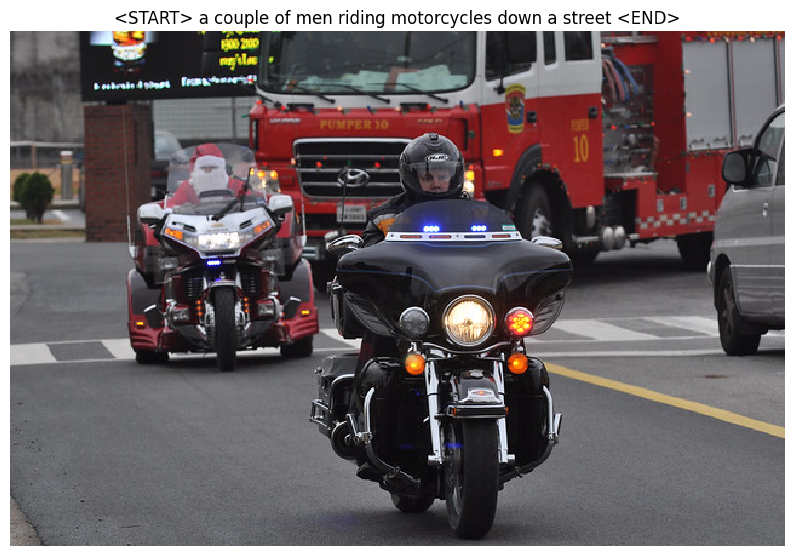

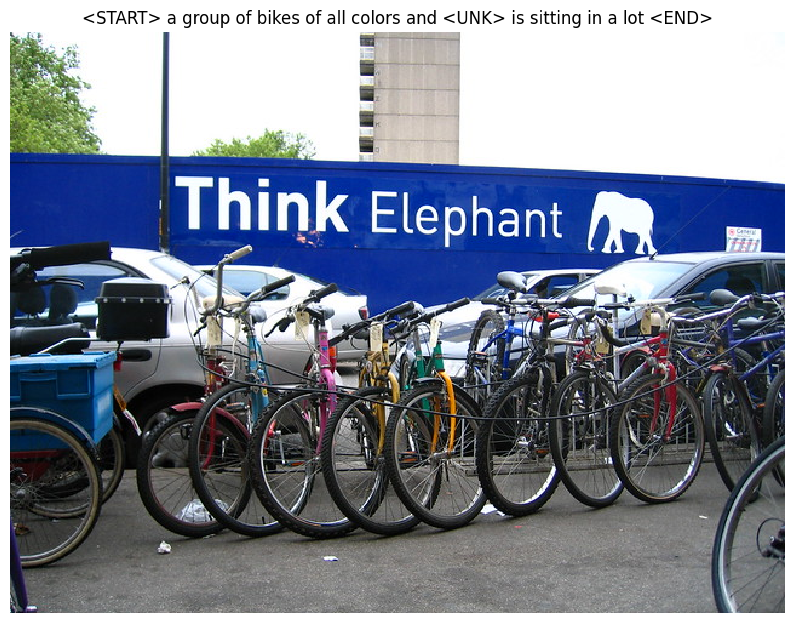

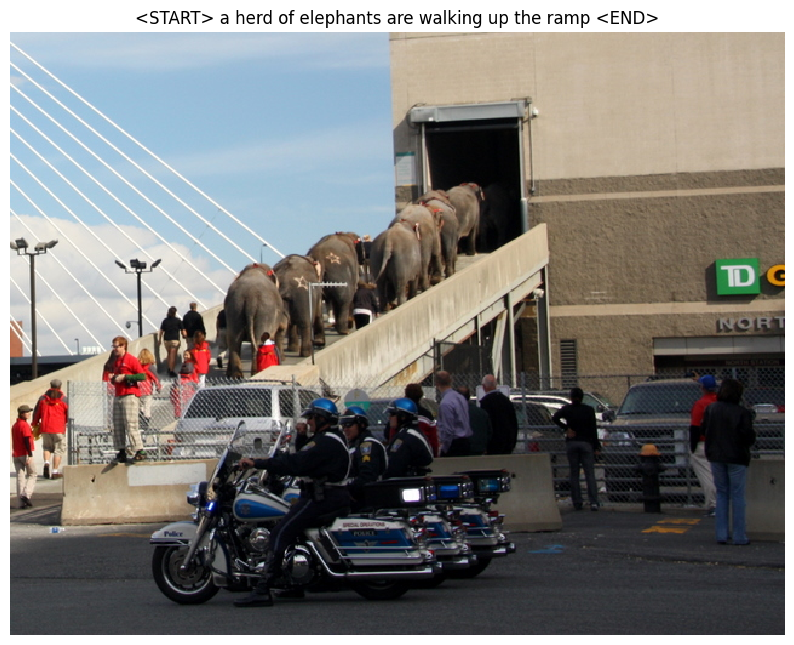

In [40]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# 순환 신경망(Recurrent Neural Networks)

이번 과제에서는 이미지 캡셔닝을 위해 순환 신경망(RNN) 기반의 언어 모델을 사용합니다.<br >
`utils/rnn_layers.py` 파일에는 RNN을 구현하는 데 필요한 다양한 레이어 타입들이 포함되어 있고,<br >
`utils/classifiers/rnn.py` 파일에서는 이러한 레이어들을 조합해 전체 이미지 캡셔닝 모델을 구성한다.<br >

먼저 `utils/rnn_layers.py` 파일에서 여러 종류의 RNN 레이어들을 직접 구현하는 것으로 과제를 대체하겠습니다😊

# Vanilla RNN: 한 스텝의 forward 연산

`utils/rnn_layers.py` 파일을 열어보자.<br >
이 파일에는 순환 신경망(RNN)에서 자주 사용되는 다양한 레이어들의 forward / backward 연산이 구현되어 있다.<br >

## Assignment 1
첫 번째 과제는 `rnn_step_forward` 함수에서 비어져있는 부분을 채웁니다.<br >
해당 함수는 `vanilla RNN`의 한 타임스텝에 대한 forward 연산을 수행한다.<br >
구현을 마친 뒤 아래 셀을 실행하면 정확도를 확인할 수 있다.<br >
올바르게 구현했다면 오차는 대략 1e-8 수준 이하로 나타난다.

In [41]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: 한 스텝의 backward 연산

# Assignment 2
`utils/rnn_layers.py` 파일에서 rnn_step_backward 함수를 완성하시오.<br >
이 함수는 `vanilla RNN`의 한 타임스텝에 대한 backward(역전파) 연산을 수행한다.<br >
구현을 마친 뒤 아래 셀을 실행하면 수치적 그래디언트 체크가 이루어진다. 올바르게 구현했다면 오차는 보통 `1e-8` 수준 이하로 나타난다.

In [45]:
from utils.rnn_layers import rnn_step_forward, rnn_step_backward
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  4.0192769090159184e-10
dprev_h error:  2.5632975303201374e-10
dWx error:  8.820222259148609e-10
dWh error:  4.703287554560559e-10
db error:  7.30162216654e-11


# Vanilla RNN: 전체 시퀀스 forward

이제 한 타임스텝에 대한 forward와 backward 연산을 구현했으므로, 이를 바탕으로 전체 시퀀스를 처리하는 RNN forward 함수를 만들어야 한다.

# Assignment 3
`utils/rnn_layers.py` 파일에서 `rnn_forward` 함수를 완성시키시오.<br >
이 함수는 앞에서 작성한 `rnn_step_forward`를 반복적으로 호출해, 입력 시퀀스 전체에 대해 RNN의 출력을 계산한다. 구현을 마친 뒤 아래 셀을 실행하면 정답과 비교하여 정확도를 확인할 수 있다. 올바르게 구현되었다면 오차는 대략 `1e-7` 수준 이하로 나타난다.

In [6]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

('h error: ', 7.7284661583051643e-08)


# Vanilla RNN: 전체 시퀀스 backward

## Assignment 4
`utils/rnn_layers.py` 파일에서 `rnn_backward` 함수를 구현하라.<br >
이 함수는 <b>전체 시퀀스에 대해 역전파(back-propagation)<b>를 수행하며, 이전에 구현한 `rnn_step_backward`를 각 타임스텝에 대해 호출해 그래디언트를 계산해야 한다.<br >
올바르게 구현했다면 수치적 그래디언트 체크에서 오차는 보통 `1e-6` 수준 이하로 나타난다.

In [7]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

('dx error: ', 1.531950838055161e-09)
('dh0 error: ', 3.3746901505769888e-09)
('dWx error: ', 7.4272411478035129e-09)
('dWh error: ', 1.3118350414505446e-07)
('db error: ', 3.0833357323771948e-10)


# 단어 임베딩: forward

딥러닝 시스템에서는 단어를 벡터로 표현하는 방식이 일반적이다.<br >
어휘(vocabulary)에 속한 각 단어는 하나의 벡터와 연결되며, 이 벡터들은 시스템의 다른 구성 요소들과 함께 공동으로 학습됩니다.<br >

## Assignment 5
`utils/rnn_layers.py` 파일에서 `word_embedding_forward` 함수를 구현하여, 정수로 표현된 단어들을 해당하는 벡터로 변환하시오. <br >
구현을 마친 뒤 아래 셀을 실행하여 결과를 확인하라. 오차는 보통 1e-8 수준 이하로 나타난다.

In [8]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

('out error: ', 1.0000000094736443e-08)


# 단어 임베딩: backward

`word_embedding_backward` 함수에서 단어 임베딩의 `backward` 연산을 구현하시오.<br >
구현을 마친 뒤 아래 셀을 실행하면 수치적 그래디언트 체크를 통해 정확도를 확인할 수 있습니다.<br >
올바르게 구현되었다면 오차는 대략 `1e-11` 수준 이하로 나타나는 것을 확인할 수 있습니다.

In [9]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

('dW error: ', 3.2774595693100364e-12)


# Temporal Affine layer

각 타임스텝마다 RNN의 hidden 벡터를 해당 시점에서의 어휘(vocabulary) 단어들에 대한 점수(score)로 변환하기 위해 `affine` 함수를 사용합니다.<br>
이 연산은 과제 2에서 구현했던 affine 레이어와 매우 유사하므로, 이번 과제에서는 `utils/rnn_layers.py` 파일에 있는 `temporal_affine_forward`와 `temporal_affine_backward` 함수를 이미 제공해 두었습니다😊<br>


아래 셀을 실행하면 이 구현에 대한 수치적 그래디언트 체크를 수행할 수 있으며,<br>
올바르게 구현되어 있다면 오차는 대략 `1e-9` 수준 이하로 나타나는 것을 볼 수 있습니다.

In [10]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

('dx error: ', 1.8055922665452894e-10)
('dw error: ', 1.5772048360019819e-10)
('db error: ', 5.2835767210201547e-12)


# Temporal Softmax loss

`RNN` 기반 언어 모델에서는 각 타임스텝마다 어휘(vocabulary)에 속한 모든 단어에 대해 점수(score)를 예측한다.<br > 그리고 각 타임스텝마다 정답 단어(ground-truth word)를 알고 있으므로, 각 시점에서 softmax loss를 사용해 손실과 그래디언트를 계산합니다.<br > 전체 시퀀스의 손실은 시간 축으로 합산하고, 마지막에 미니배치 크기로 평균을 냅니다.<br >

하지만 한 가지 주의할 점이 있습니다.<br > 미니배치 내에서 캡션 길이가 서로 다르기 때문에, 모든 캡션의 길이를 동일하게 맞추기 위해 각 캡션 끝에 `<NULL>` 토큰을 붙여햐 합니다.<br >
이 `<NULL>` 토큰은 실제 단어가 아니므로, 손실과 그래디언트 계산에서 제외해야 합니다.<br> 이를 위해 loss 함수는 점수(scores)와 정답 라벨 외에도, 어떤 위치가 손실에 포함되어야 하는지를 알려주는 mask 배열을 입력으로 받습니다.<br>

이 연산은 과제 1에서 구현했던 softmax loss와 매우 유사하므로, 이미 구현된 버전을 제공하였습니다.<br>
`utils/rnn_layers.py` 파일의 `temporal_softmax_loss` 함수를 참고해주세요!

아래 셀을 실행하면 loss 값이 정상인지 확인하고, 수치적 그래디언트 체크를 수행할 수 있습니다.<br>
dx에 대한 오차는 보통 `1e-7` 수준 이하로 나타나는 것을 확인 할 수 있습니다.

In [46]:
# Sanity check for temporal softmax loss
from utils.rnn_layers import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3027204336129823
23.025583689680193
2.267118054685722
dx error:  4.641052218096008e-08


# 이미지 캡셔닝을 위한 RNN

이제 필요한 모든 레이어들을 구현했으니, 이를 조합해 실제 이미지 캡셔닝 모델을 만들 수 있습니다.<br>
`utils/classifiers/rnn.py` 파일을 열고 `CaptioningRNN` 클래스를 참고하시오.<br >

## Assignment 6
이제 loss 함수 안에서 모델의 `forward`와 `backward` 과정을 구현해야 합니다.<br >
지금은 `cell_type='rnn'`인 `vanilla RNN` 경우만 구현하면 되고, `LSTM`은 나중에 따로 구현하게 된다.<br>
구현이 끝나면 아래 셀을 실행해 작은 테스트 케이스로 `forward pass`가 올바르게 동작하는지 확인할 수 있다.<br> 정상적으로 구현했다면 오차는 대략 `1e-10` 수준 이하로 나타납니다.

In [47]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

NameError: name '_____' is not defined

아래 셀을 실행하여 CaptioningRNN 클래스에 대한 수치적 그래디언트 체크를 수행하시오.<br>
정상적으로 구현되었다면 오차는 보통 1e-6 정도 수준으로 나타날 것입니다..

In [13]:
np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='rnn',
          dtype=np.float64,
        )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 2.331071e-09
W_proj relative error: 9.974427e-09
W_vocab relative error: 4.274378e-09
Wh relative error: 5.247017e-09
Wx relative error: 1.590657e-06
b relative error: 9.727211e-10
b_proj relative error: 1.934807e-08
b_vocab relative error: 1.690334e-09


# 작은 데이터에 과적합시키기(Overfit small data)

이전 과제에서 이미지 분류 모델을 학습할 때 사용했던 Solver 클래스와 비슷하게, 이번 과제에서는 이미지 캡셔닝 모델을 학습하기 위해 `CaptioningSolver` 클래스를 사용합니다.<br>
`utils/captioning_solver.py` 파일을 열어 `CaptioningSolver` 클래스를 살펴보시오.<br >
구조와 동작 방식이 매우 익숙하게 느껴질 것입니다.

API에 익숙해졌다면, 아래 셀을 실행하여 훈련 데이터 100개만을 사용해 모델이 과적합되는지 확인하시오.
올바르게 구현되었다면 최종 loss는 `0.1` 이하까지 내려가는 것을 볼 수 있다.

In [49]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

NameError: name '__________' is not defined

# 테스트 시점의 샘플링(Test-time sampling)

분류 모델과 달리, 이미지 캡셔닝 모델은 훈련 시점과 테스트 시점에서 동작 방식이 크게 다릅니다.<br>
훈련할 때는 정답 캡션을 알고 있으므로, 각 타임스텝마다 정답 단어를 RNN의 입력으로 넣는다.<br>
하지만 테스트할 때는 정답이 없기 때문에, 각 타임스텝에서 어휘 분포에서 단어를 샘플링(sampling) 하고, 그 단어를 다음 타임스텝의 입력으로 사용합니다.<br>

## Assignment 7
`utils/classifiers/rnn.py` 파일에서 테스트 시 샘플링을 위한 `sample` 함수를 구현하시오.<br>
구현을 마친 뒤 아래 셀을 실행하면, 과도하게 학습(overfit)된 모델을 이용해 학습 데이터와 검증 데이터 모두에서 샘플 캡션을 생성해볼 수 있습니다.<br>
학습 데이터에 대한 샘플은 상당히 자연스럽게 나오겠지만, 검증 데이터에 대한 샘플은 대체로 말이 되지 않을 가능성이 높습니다.

In [48]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

NameError: name 'small_data' is not defined